In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl

## load data

In [41]:
#for future use, load from pickle
snli_val = pkl.load(open("data/snli/snli_val.p", "rb"))
snli_train = pkl.load(open("data/SNLI/snli_train.p", "rb"))
all_train_tokens = pkl.load(open("data/SNLI/all_train_tokens.p", "rb"))


In [278]:
class LIDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, sent1_list, sent2_list, label_list, max_sentence_length):

        self.sent1_list = sent1_list
        self.sent2_list = sent2_list
        self.label_list = label_list
        self.max_sentence_length = max_sentence_length
        assert (len(self.sent1_list) == len(self.label_list))
        assert (len(self.sent2_list) == len(self.label_list))

    def __len__(self):
        return len(self.label_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx1 = self.sent1_list[key][:self.max_sentence_length]
        token_idx2 = self.sent2_list[key][:self.max_sentence_length]
        label = self.label_list[key]
        return [token_idx1, token_idx2, len(token_idx1), len(token_idx2), label, self.max_sentence_length]
    
def collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length: tell dataloader how to pad our sentences
    """
    sent1_list = []
    sent2_list = []
    label_list = []
    length1_list = []
    length2_list = []
    max_sentence_length = 0
    for datum in batch:
        label_list.append(datum[4])
        length1_list.append(datum[2])
        length2_list.append(datum[3])
        max_sentence_length = datum[5]
    # padding
    for datum in batch:
        padded_vec1 = np.pad(np.array(datum[0]), 
                                pad_width=((0,max_sentence_length-datum[2])), 
                                mode="constant", constant_values=0)
        sent1_list.append(padded_vec1) # list of np.array
        padded_vec2 = np.pad(np.array(datum[1]), 
                                pad_width=((0,max_sentence_length-datum[3])), 
                                mode="constant", constant_values=0)
        sent2_list.append(padded_vec2)
        
    return [torch.from_numpy(np.array(sent1_list)),torch.from_numpy(np.array(sent2_list)),torch.LongTensor(length1_list), torch.LongTensor(length2_list),torch.LongTensor(label_list)]

In [279]:
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

# build vocab
def build_vocab(all_tokens,max_vocab_size):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    print(len(id2token))
    return token2id, id2token

# convert token to id in the dataset
def token2index_dataset(tokens_data, token2id):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

def get_indices(dataset, token2id):
    indices1 = token2index_dataset(dataset['sentence1'], token2id)
    indices2 = token2index_dataset(dataset['sentence2'], token2id)
    return indices1,indices2


def get_dataloader(dataset, max_vocab_size, max_sentence_length,batch_size):
    token2id, id2token = build_vocab(all_train_tokens, max_vocab_size)
    indices1, indices2 = get_indices(dataset, token2id)
    dataset = LIDataset(indices1,indices2,dataset['label'].to_list(), max_sentence_length)
    data_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                           batch_size=batch_size,
                                           collate_fn=collate_func,
                                           shuffle=True)
    return data_loader


In [280]:
MAX_SENTENCE_LENGTH = max(max(snli_train['sentence1'].apply(len)),max(snli_train['sentence2'].apply(len)))
print(MAX_SENTENCE_LENGTH)
train_loader = get_dataloader(snli_train, max_vocab_size=7000, max_sentence_length=MAX_SENTENCE_LENGTH, batch_size=32)
val_loader = get_dataloader(snli_val, max_vocab_size=7000, max_sentence_length=MAX_SENTENCE_LENGTH, batch_size=32)

78
7002
7002


##  Build Neural Network
- A fully connected neural network with two hidden layers

In [281]:
class NNModel(nn.Module):
    """
    NN classification model
    """
    def __init__(self, vocab_size, emb_dim, hidden1,hidden2,sent_interact,dropout):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(NNModel, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.sent_interact=sent_interact
        if sent_interact=='concat':
            self.nn_layer = nn.Sequential(
                            nn.Linear(2*emb_dim,hidden1),
                            nn.ReLU(),
                            nn.Dropout(p=dropout),
                            nn.Linear(hidden1,hidden2),
                            nn.ReLU(),
                            nn.Dropout(p=dropout),
                            nn.Linear(hidden2,3))
        else:
            self.nn_layer = nn.Sequential(
                            nn.Linear(emb_dim,hidden1),
                            nn.ReLU(),
                            nn.Linear(hidden1,hidden2),
                            nn.ReLU(),
                            nn.Linear(hidden2,3))
               
    def forward(self, sent1, sent2, length1, length2):
        """
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out1 = self.embed(sent1)
        out2 = self.embed(sent2)
        out1 = torch.sum(out1, dim=1)
        out1 /= length1.view(length1.size()[0],1).expand_as(out1).float()
        out2 = torch.sum(out2, dim=1)
        out2 /= length2.view(length2.size()[0],1).expand_as(out2).float()
        
        # return logits
        if self.sent_interact == 'concat':
            out = self.nn_layer(torch.cat((out1, out2), 1))
        if self.sent_interact == 'add':
            out = self.nn_layer(out1.add(out2))
        if self.sent_interact == 'mul':
            out = self.nn_layer(out1.mul(out2))
        return out

In [282]:
import time
# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for sent1,sent2,length1,length2, labels in loader:
        outputs = F.softmax(model(sent1,sent2,length1,length2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

def run(model, train_loader, val_loader, optimizer,lr_desc_per_ep, criterion, num_epochs,params):
    time1 = time.time()
    best_val_acc = 0
    val_acc_epoch = []
    avg_val_acc_list = []
    
    loss_epoch = []
    avg_loss_list = []
    
    epoch_list = []
    for epoch in range(num_epochs):
        for optim_param_g in optimizer.param_groups:
            optim_param_g['lr'] -= lr_desc_per_ep
            if optim_param_g['lr'] <= 0:
                raise ValueError('Negative Learning Rate Error. Pls check param setting.')
        epoch_list.append(epoch+1)
        for i, (sent1,sent2,length1,length2,labels) in enumerate(train_loader):
            model.train() #put in training mode
            optimizer.zero_grad() #Sets gradients of all model parameters to zero. model.zero_grad() and optimizer.zero_grad() are the same IF all your model parameters are in that optimizer. I found it is safer to call model.zero_grad() to make sure all grads are zero, e.g. if you have two or more optimizers for one model.
            outputs = model(sent1, sent2, length1, length2)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                val_acc_epoch.append(val_acc)
                loss_epoch.append(loss.item())
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}, the best Acc per epoch:{}, Loss: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc, best_val_acc,loss))
                
        avg_val_acc = sum(val_acc_epoch)/len(val_acc_epoch)
        best_val_acc = max(avg_val_acc,best_val_acc)
        avg_val_acc_list.append(avg_val_acc)
        
        avg_loss = sum(loss_epoch)/len(loss_epoch)
        avg_loss_list.append(avg_loss)
    df = pd.DataFrame(list(zip(epoch_list,avg_val_acc_list, avg_loss_list)), columns =['epoch','avg_val_acc/epoch', 'avg_loss/epoch']) 
    df['best_val_acc/epoch'] = best_val_acc
    
    for key in params.keys():
        df[key] = params[key]
        
    time2 = time.time()
    print((time2-time1)/60)
    return df,model

In [49]:
# SNLI
criterion = torch.nn.CrossEntropyLoss()  
learning_rate = 0.01
weight_decay = 1e-06
DROPOUT = 0.05
model = NNModel(vocab_size=7002,emb_dim=30,hidden1=30,hidden2=30,sent_interact='concat',dropout=DROPOUT)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay = weight_decay)
PARAMS = {'dataset':'SNLI','max_sentence_length':MAX_SENTENCE_LENGTH,'vocab_size':7000,'emb_dim':30,'initial_learning_rate':0.01,'Linear Annealing rate':0.0009,'weight_decay':1e-06,'dropout':DROPOUT}
df_snli,best_model = run(model,train_loader = train_loader,val_loader=val_loader,optimizer=optimizer,lr_desc_per_ep=0.0009,criterion=criterion,num_epochs=10,params = PARAMS)

Epoch: [1/10], Step: [101/3125], Validation Acc: 44.5, the best Acc per epoch:0, Loss: 1.0205844640731812
Epoch: [1/10], Step: [201/3125], Validation Acc: 51.1, the best Acc per epoch:0, Loss: 0.985029935836792
Epoch: [1/10], Step: [301/3125], Validation Acc: 52.5, the best Acc per epoch:0, Loss: 1.086435317993164
Epoch: [1/10], Step: [401/3125], Validation Acc: 54.8, the best Acc per epoch:0, Loss: 0.9922974109649658
Epoch: [1/10], Step: [501/3125], Validation Acc: 56.9, the best Acc per epoch:0, Loss: 0.7605890035629272
Epoch: [1/10], Step: [601/3125], Validation Acc: 58.3, the best Acc per epoch:0, Loss: 0.8433148264884949
Epoch: [1/10], Step: [701/3125], Validation Acc: 58.8, the best Acc per epoch:0, Loss: 0.9333438277244568
Epoch: [1/10], Step: [801/3125], Validation Acc: 57.7, the best Acc per epoch:0, Loss: 0.9613198041915894
Epoch: [1/10], Step: [901/3125], Validation Acc: 59.3, the best Acc per epoch:0, Loss: 0.8064236640930176
Epoch: [1/10], Step: [1001/3125], Validation Acc

Epoch: [3/10], Step: [1201/3125], Validation Acc: 63.9, the best Acc per epoch:62.1, Loss: 0.8036160469055176
Epoch: [3/10], Step: [1301/3125], Validation Acc: 63.8, the best Acc per epoch:62.1, Loss: 0.7040817141532898
Epoch: [3/10], Step: [1401/3125], Validation Acc: 64.9, the best Acc per epoch:62.1, Loss: 0.6202788949012756
Epoch: [3/10], Step: [1501/3125], Validation Acc: 64.2, the best Acc per epoch:62.1, Loss: 0.8033412098884583
Epoch: [3/10], Step: [1601/3125], Validation Acc: 65.2, the best Acc per epoch:62.1, Loss: 1.0285000801086426
Epoch: [3/10], Step: [1701/3125], Validation Acc: 65.4, the best Acc per epoch:62.1, Loss: 0.6782925724983215
Epoch: [3/10], Step: [1801/3125], Validation Acc: 63.9, the best Acc per epoch:62.1, Loss: 0.937810480594635
Epoch: [3/10], Step: [1901/3125], Validation Acc: 63.7, the best Acc per epoch:62.1, Loss: 0.8229625821113586
Epoch: [3/10], Step: [2001/3125], Validation Acc: 65.6, the best Acc per epoch:62.1, Loss: 1.053617238998413
Epoch: [3/10

Epoch: [5/10], Step: [1901/3125], Validation Acc: 67.2, the best Acc per epoch:63.77419354838707, Loss: 0.6488662362098694
Epoch: [5/10], Step: [2001/3125], Validation Acc: 67.9, the best Acc per epoch:63.77419354838707, Loss: 0.5912670493125916
Epoch: [5/10], Step: [2101/3125], Validation Acc: 67.2, the best Acc per epoch:63.77419354838707, Loss: 0.5105772614479065
Epoch: [5/10], Step: [2201/3125], Validation Acc: 67.7, the best Acc per epoch:63.77419354838707, Loss: 0.6655132174491882
Epoch: [5/10], Step: [2301/3125], Validation Acc: 67.3, the best Acc per epoch:63.77419354838707, Loss: 0.6096734404563904
Epoch: [5/10], Step: [2401/3125], Validation Acc: 65.6, the best Acc per epoch:63.77419354838707, Loss: 0.6882439851760864
Epoch: [5/10], Step: [2501/3125], Validation Acc: 67.4, the best Acc per epoch:63.77419354838707, Loss: 0.6376163363456726
Epoch: [5/10], Step: [2601/3125], Validation Acc: 66.3, the best Acc per epoch:63.77419354838707, Loss: 0.5453469157218933
Epoch: [5/10], S

Epoch: [7/10], Step: [2501/3125], Validation Acc: 67.6, the best Acc per epoch:64.83333333333331, Loss: 0.6389329433441162
Epoch: [7/10], Step: [2601/3125], Validation Acc: 67.0, the best Acc per epoch:64.83333333333331, Loss: 0.5559753775596619
Epoch: [7/10], Step: [2701/3125], Validation Acc: 67.7, the best Acc per epoch:64.83333333333331, Loss: 0.6849541664123535
Epoch: [7/10], Step: [2801/3125], Validation Acc: 67.1, the best Acc per epoch:64.83333333333331, Loss: 0.5091063380241394
Epoch: [7/10], Step: [2901/3125], Validation Acc: 67.3, the best Acc per epoch:64.83333333333331, Loss: 0.47380685806274414
Epoch: [7/10], Step: [3001/3125], Validation Acc: 66.9, the best Acc per epoch:64.83333333333331, Loss: 0.5296118855476379
Epoch: [7/10], Step: [3101/3125], Validation Acc: 67.5, the best Acc per epoch:64.83333333333331, Loss: 0.4399006962776184
Epoch: [8/10], Step: [101/3125], Validation Acc: 68.7, the best Acc per epoch:65.1880184331797, Loss: 0.7690888047218323
Epoch: [8/10], St

Epoch: [9/10], Step: [3001/3125], Validation Acc: 66.9, the best Acc per epoch:65.45766129032256, Loss: 0.7205643057823181
Epoch: [9/10], Step: [3101/3125], Validation Acc: 67.0, the best Acc per epoch:65.45766129032256, Loss: 0.2789859175682068
Epoch: [10/10], Step: [101/3125], Validation Acc: 67.4, the best Acc per epoch:65.6236559139785, Loss: 0.14343202114105225
Epoch: [10/10], Step: [201/3125], Validation Acc: 66.1, the best Acc per epoch:65.6236559139785, Loss: 0.3447074294090271
Epoch: [10/10], Step: [301/3125], Validation Acc: 67.9, the best Acc per epoch:65.6236559139785, Loss: 0.3474304974079132
Epoch: [10/10], Step: [401/3125], Validation Acc: 67.7, the best Acc per epoch:65.6236559139785, Loss: 0.31630581617355347
Epoch: [10/10], Step: [501/3125], Validation Acc: 67.1, the best Acc per epoch:65.6236559139785, Loss: 0.2772015333175659
Epoch: [10/10], Step: [601/3125], Validation Acc: 67.1, the best Acc per epoch:65.6236559139785, Loss: 0.3587976098060608
Epoch: [10/10], Step

In [50]:
df_snli

,epoch,avg_val_acc/epoch,avg_loss/epoch,best_val_acc/epoch,dataset,max_sentence_length,vocab_size,emb_dim,initial_learning_rate,Linear Annealing rate,weight_decay,dropout
0,1,59.948387,0.865866,65.770645,SNLI,78,7000,30,0.01,0.0009,0.000001,0.05
1,2,62.100000,0.798111,65.770645,SNLI,78,7000,30,0.01,0.0009,0.000001,0.05
2,3,63.133333,0.774734,65.770645,SNLI,78,7000,30,0.01,0.0009,0.000001,0.05
3,4,63.774194,0.742192,65.770645,SNLI,78,7000,30,0.01,0.0009,0.000001,0.05
4,5,64.351613,0.708505,65.770645,SNLI,78,7000,30,0.01,0.0009,0.000001,0.05
5,6,64.833333,0.685164,65.770645,SNLI,78,7000,30,0.01,0.0009,0.000001,0.05
6,7,65.188018,0.666031,65.770645,SNLI,78,7000,30,0.01,0.0009,0.000001,0.05
7,8,65.457661,0.641034,65.770645,SNLI,78,7000,30,0.01,0.0009,0.000001,0.05
8,9,65.623656,0.614982,65.770645,SNLI,78,7000,30,0.01,0.0009,0.000001,0.05
9,10,65.770645,0.589055,65.770645,SNLI,78,7000,30,0.01,0.0009,0.000001,0.05


In [51]:
import copy
best_model=copy.deepcopy(best_model)
pkl.dump(best_model, open("best_model.p", "wb"))

## 3.2 & 3.3

In [284]:
#ybx's best model
from snli_param_tune_lib import *
best = pkl.load(open("ybx_best_model.pkl", "rb"))
print(best['info'])
best_model = best['model']

{'vocabulary_size': 7000, 'embedding_dimension': 30, 'hidden_dimension1': 30, 'hidden_dimension2': 30, 'sentences_interaction': 'concatenate', 'optimizer': 'Adam', 'learning_rate': 0.01, 'lr_desc_per_ep': 0.0009, 'weight_decay': 1e-06, 'drop_out': 0.05, 'max_sentence_length': 50, 'best_val_acc': 68.7, '@epoch': 8, 'num_epochs': 10, '@step': 101, 'total_steps': 3125, '@train_loss': 0.483, 'time_per_epoch(min)': 5.336699211597443}


In [285]:
# Function for ybx's bestmodel
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for sent1,sent2,length1,length2, labels in loader:
        outputs = F.softmax(model(sent1,length1,sent2,length2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)
def run(model, train_loader, val_loader, optimizer,lr_desc_per_ep, criterion, num_epochs,params):
    time1 = time.time()
    best_val_acc = 0
    val_acc_epoch = []
    avg_val_acc_list = []
    
    loss_epoch = []
    avg_loss_list = []
    
    epoch_list = []
    for epoch in range(num_epochs):
        for optim_param_g in optimizer.param_groups:
            optim_param_g['lr'] -= lr_desc_per_ep
            if optim_param_g['lr'] <= 0:
                raise ValueError('Negative Learning Rate Error. Pls check param setting.')
        epoch_list.append(epoch+1)
        for i, (sent1,sent2,length1,length2,labels) in enumerate(train_loader):
            model.train() #put in training mode
            optimizer.zero_grad() #Sets gradients of all model parameters to zero. model.zero_grad() and optimizer.zero_grad() are the same IF all your model parameters are in that optimizer. I found it is safer to call model.zero_grad() to make sure all grads are zero, e.g. if you have two or more optimizers for one model.
            outputs = model(sent1, length1,sent2,length2)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                val_acc_epoch.append(val_acc)
                loss_epoch.append(loss.item())
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}, the best Acc per epoch:{}, Loss: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc, best_val_acc,loss))
                
        avg_val_acc = sum(val_acc_epoch)/len(val_acc_epoch)
        best_val_acc = max(avg_val_acc,best_val_acc)
        avg_val_acc_list.append(avg_val_acc)
        
        avg_loss = sum(loss_epoch)/len(loss_epoch)
        avg_loss_list.append(avg_loss)
    df = pd.DataFrame(list(zip(epoch_list,avg_val_acc_list, avg_loss_list)), columns =['epoch','avg_val_acc/epoch', 'avg_loss/epoch']) 
    df['best_val_acc/epoch'] = best_val_acc
    
    for key in params.keys():
        df[key] = params[key]
        
    time2 = time.time()
    print((time2-time1)/60)
    return df,model

In [286]:
mnli_train_telephone = pkl.load(open("data/MNLI/mnli_train_telephone.p", "rb"))
mnli_train_fiction = pkl.load(open("data/MNLI/mnli_train_fiction.p", "rb"))
mnli_train_slate = pkl.load(open("data/MNLI/mnli_train_slate.p", "rb"))
mnli_train_government = pkl.load(open("data/MNLI/mnli_train_government.p", "rb"))
mnli_train_travel = pkl.load(open("data/MNLI/mnli_train_travel.p", "rb"))
mnli_val_telephone = pkl.load(open("data/MNLI/mnli_val_telephone.p", "rb"))
mnli_val_fiction = pkl.load(open("data/MNLI/mnli_val_fiction.p", "rb"))
mnli_val_slate = pkl.load(open("data/MNLI/mnli_val_slate.p", "rb"))
mnli_val_government = pkl.load(open("data/MNLI/mnli_val_government.p", "rb"))
mnli_val_travel = pkl.load(open("data/MNLI/mnli_val_travel.p", "rb"))

In [14]:
# load the best NN model
best_model = pkl.load(open("best_model.p", "rb"))
best_model.embed.weight.shape

torch.Size([7002, 30])

In [290]:
#telephone
best_model = pkl.load(open("ybx_best_model.pkl", "rb"))['model']
# best_model = pkl.load(open('best_model.p','rb')) #mine
MAX_SENTENCE_LENGTH = max(max(mnli_train_telephone['sentence1'].apply(len)),max(mnli_train_telephone['sentence2'].apply(len)))
print(MAX_SENTENCE_LENGTH)
train_loader = get_dataloader(mnli_train_telephone, max_vocab_size=7000, max_sentence_length=MAX_SENTENCE_LENGTH, batch_size=32)
val_loader = get_dataloader(mnli_val_telephone, max_vocab_size=7000, max_sentence_length=MAX_SENTENCE_LENGTH, batch_size=32)

criterion = torch.nn.CrossEntropyLoss()  
learning_rate = 0.005
optimizer = torch.optim.Adam(best_model.parameters(), lr=learning_rate)
PARAMS = {'dataset':'telephone','vocab_size':7000,'emb_dim':30,'initial_learning_rate':0.005}
df_tele,model_tele = run(best_model,train_loader = train_loader,val_loader=val_loader,optimizer=optimizer,lr_desc_per_ep=0,criterion=criterion,num_epochs=8,params = PARAMS)

242
Epoch: [1/8], Step: [101/134], Validation Acc: 46.069651741293534, the best Acc per epoch:0, Loss: 1.2415660619735718
Epoch: [2/8], Step: [101/134], Validation Acc: 47.960199004975124, the best Acc per epoch:46.069651741293534, Loss: 1.038446068763733
Epoch: [3/8], Step: [101/134], Validation Acc: 49.75124378109453, the best Acc per epoch:47.01492537313433, Loss: 0.9221481680870056
Epoch: [4/8], Step: [101/134], Validation Acc: 49.45273631840796, the best Acc per epoch:47.927031509121065, Loss: 0.8321449756622314
Epoch: [5/8], Step: [101/134], Validation Acc: 48.85572139303483, the best Acc per epoch:48.308457711442784, Loss: 0.7441638112068176
Epoch: [6/8], Step: [101/134], Validation Acc: 48.85572139303483, the best Acc per epoch:48.417910447761194, Loss: 0.5929828882217407
Epoch: [7/8], Step: [101/134], Validation Acc: 47.960199004975124, the best Acc per epoch:48.49087893864013, Loss: 0.4141455590724945
Epoch: [8/8], Step: [101/134], Validation Acc: 48.059701492537314, the best

In [292]:
df_tele

,epoch,avg_val_acc/epoch,avg_loss/epoch,best_val_acc/epoch,dataset,vocab_size,emb_dim,initial_learning_rate
0,1,46.069652,1.241566,48.490879,telephone,7000,30,0.005
1,2,47.014925,1.140006,48.490879,telephone,7000,30,0.005
2,3,47.927032,1.067387,48.490879,telephone,7000,30,0.005
3,4,48.308458,1.008576,48.490879,telephone,7000,30,0.005
4,5,48.417910,0.955694,48.490879,telephone,7000,30,0.005
5,6,48.490879,0.895242,48.490879,telephone,7000,30,0.005
6,7,48.415068,0.826514,48.490879,telephone,7000,30,0.005
7,8,48.370647,0.806074,48.490879,telephone,7000,30,0.005


In [316]:
# test models that are fine-tuned on every other genre
best_model = pkl.load(open("ybx_best_model.pkl", "rb"))['model']

MAX_SENTENCE_LENGTH = max(max(mnli_train_telephone['sentence1'].apply(len)),max(mnli_train_telephone['sentence2'].apply(len)))
print(MAX_SENTENCE_LENGTH)
train_loader = get_dataloader(mnli_train_telephone, max_vocab_size=7000, max_sentence_length=MAX_SENTENCE_LENGTH, batch_size=32)
val_loader = get_dataloader(mnli_val_telephone, max_vocab_size=7000, max_sentence_length=MAX_SENTENCE_LENGTH, batch_size=32)

print('without_finetune:',test_model(val_loader,best_model))
print('finetuned on tele:',test_model(val_loader,model_tele))
print('finetuned on fic:',test_model(val_loader,model_fic))
print('finetuned on slate:',test_model(val_loader,model_slate))
print('finetuned on gov:',test_model(val_loader,model_gov))
print('finetuned on travel:',test_model(val_loader,model_travel))

242
without_finetune: 44.776119402985074
finetuned on tele: 46.766169154228855
finetuned on fic: 47.36318407960199
finetuned on slate: 47.86069651741293
finetuned on gov: 49.25373134328358
finetuned on travel: 47.56218905472637


In [293]:
#fiction
#load model
best_model = pkl.load(open("ybx_best_model.pkl", "rb"))['model']
# best_model = pkl.load(open('best_model.p','rb')) #mine

MAX_SENTENCE_LENGTH = max(max(mnli_train_fiction['sentence1'].apply(len)),max(mnli_train_fiction['sentence2'].apply(len)))
print(MAX_SENTENCE_LENGTH)
train_loader = get_dataloader(mnli_train_fiction, max_vocab_size=7000, max_sentence_length=MAX_SENTENCE_LENGTH, batch_size=32)
val_loader = get_dataloader(mnli_val_fiction, max_vocab_size=7000, max_sentence_length=MAX_SENTENCE_LENGTH, batch_size=32)

criterion = torch.nn.CrossEntropyLoss()  
learning_rate = 0.005
optimizer = torch.optim.Adam(best_model.parameters(), lr=learning_rate)
PARAMS = {'dataset':'fiction','vocab_size':7000,'emb_dim':30,'initial_learning_rate':0.005}
df_fic,model_fic = run(best_model,train_loader = train_loader,val_loader=val_loader,optimizer=optimizer,lr_desc_per_ep=0,criterion=criterion,num_epochs=8,params = PARAMS)

14561
Epoch: [1/8], Step: [101/120], Validation Acc: 41.80904522613066, the best Acc per epoch:0, Loss: 1.1413229703903198
Epoch: [2/8], Step: [101/120], Validation Acc: 46.030150753768844, the best Acc per epoch:41.80904522613066, Loss: 0.9331798553466797
Epoch: [3/8], Step: [101/120], Validation Acc: 48.64321608040201, the best Acc per epoch:43.91959798994975, Loss: 0.8608289957046509
Epoch: [4/8], Step: [101/120], Validation Acc: 47.8391959798995, the best Acc per epoch:45.494137353433835, Loss: 0.7717059850692749
Epoch: [5/8], Step: [101/120], Validation Acc: 47.93969849246231, the best Acc per epoch:46.08040201005025, Loss: 0.739737868309021
Epoch: [6/8], Step: [101/120], Validation Acc: 47.73869346733668, the best Acc per epoch:46.45226130653266, Loss: 0.44868767261505127
Epoch: [7/8], Step: [101/120], Validation Acc: 47.63819095477387, the best Acc per epoch:46.666666666666664, Loss: 0.7219975590705872
Epoch: [8/8], Step: [101/120], Validation Acc: 48.34170854271357, the best Ac

In [294]:
df_fic

,epoch,avg_val_acc/epoch,avg_loss/epoch,best_val_acc/epoch,dataset,vocab_size,emb_dim,initial_learning_rate
0,1,41.809045,1.141323,46.997487,fiction,7000,30,0.005
1,2,43.919598,1.037251,46.997487,fiction,7000,30,0.005
2,3,45.494137,0.978444,46.997487,fiction,7000,30,0.005
3,4,46.080402,0.926759,46.997487,fiction,7000,30,0.005
4,5,46.452261,0.889355,46.997487,fiction,7000,30,0.005
5,6,46.666667,0.815911,46.997487,fiction,7000,30,0.005
6,7,46.805456,0.802494,46.997487,fiction,7000,30,0.005
7,8,46.997487,0.756611,46.997487,fiction,7000,30,0.005


In [321]:
# test models that are fine-tuned on every other genre
best_model = pkl.load(open("ybx_best_model.pkl", "rb"))['model']

MAX_SENTENCE_LENGTH = max(max(mnli_train_fiction['sentence1'].apply(len)),max(mnli_train_fiction['sentence2'].apply(len)))
print(MAX_SENTENCE_LENGTH)
train_loader = get_dataloader(mnli_train_fiction, max_vocab_size=7000, max_sentence_length=MAX_SENTENCE_LENGTH, batch_size=32)
val_loader = get_dataloader(mnli_val_fiction, max_vocab_size=7000, max_sentence_length=MAX_SENTENCE_LENGTH, batch_size=32)

print('without_finetune:',round(test_model(val_loader,best_model),6))
print('finetuned on tele:',round(test_model(val_loader,model_tele),6))
print('finetuned on fic:',round(test_model(val_loader,model_fic),6))
print('finetuned on slate:',round(test_model(val_loader,model_slate),6))
print('finetuned on gov:',round(test_model(val_loader,model_gov),6))
print('finetuned on travel:',round(test_model(val_loader,model_travel),6))

14561
without_finetune: 43.417085
finetuned on tele: 44.522613
finetuned on fic: 47.638191
finetuned on slate: 46.532663
finetuned on gov: 49.849246
finetuned on travel: 44.924623


In [301]:
#slate
best_model = pkl.load(open("ybx_best_model.pkl", "rb"))['model']
# best_model = pkl.load(open('best_model.p','rb')) #mine
MAX_SENTENCE_LENGTH = max(max(mnli_train_slate['sentence1'].apply(len)),max(mnli_train_slate['sentence2'].apply(len)))
print(MAX_SENTENCE_LENGTH)
train_loader = get_dataloader(mnli_train_slate, max_vocab_size=7000, max_sentence_length=MAX_SENTENCE_LENGTH, batch_size=32)
val_loader = get_dataloader(mnli_val_slate, max_vocab_size=7000, max_sentence_length=MAX_SENTENCE_LENGTH, batch_size=32)

criterion = torch.nn.CrossEntropyLoss()  
learning_rate = 0.005
optimizer = torch.optim.Adam(best_model.parameters(), lr=learning_rate)
PARAMS = {'dataset':'slate','vocab_size':7000,'emb_dim':30,'initial_learning_rate':0.005}
df_slate,model_slate = run(best_model,train_loader = train_loader,val_loader=val_loader,optimizer=optimizer,lr_desc_per_ep=0,criterion=criterion,num_epochs=8,params = PARAMS)

94
Epoch: [1/8], Step: [101/126], Validation Acc: 42.71457085828343, the best Acc per epoch:0, Loss: 1.0208021402359009
Epoch: [2/8], Step: [101/126], Validation Acc: 43.712574850299404, the best Acc per epoch:42.71457085828343, Loss: 1.046647071838379
Epoch: [3/8], Step: [101/126], Validation Acc: 45.209580838323355, the best Acc per epoch:43.213572854291414, Loss: 0.9266634583473206
Epoch: [4/8], Step: [101/126], Validation Acc: 44.71057884231537, the best Acc per epoch:43.87890884896873, Loss: 0.8320544362068176
Epoch: [5/8], Step: [101/126], Validation Acc: 44.01197604790419, the best Acc per epoch:44.08682634730539, Loss: 0.7238216996192932
Epoch: [6/8], Step: [101/126], Validation Acc: 44.11177644710579, the best Acc per epoch:44.08682634730539, Loss: 0.6064199805259705
Epoch: [7/8], Step: [101/126], Validation Acc: 41.417165668662676, the best Acc per epoch:44.08682634730539, Loss: 0.4663418233394623
Epoch: [8/8], Step: [101/126], Validation Acc: 42.315369261477045, the best Acc

In [302]:
df_slate

,epoch,avg_val_acc/epoch,avg_loss/epoch,best_val_acc/epoch,dataset,vocab_size,emb_dim,initial_learning_rate
0,1,42.714571,1.020802,44.086826,slate,7000,30,0.005
1,2,43.213573,1.033725,44.086826,slate,7000,30,0.005
2,3,43.878909,0.998038,44.086826,slate,7000,30,0.005
3,4,44.086826,0.956542,44.086826,slate,7000,30,0.005
4,5,44.071856,0.909998,44.086826,slate,7000,30,0.005
5,6,44.078510,0.859401,44.086826,slate,7000,30,0.005
6,7,43.698318,0.803250,44.086826,slate,7000,30,0.005
7,8,43.525449,0.756074,44.086826,slate,7000,30,0.005


In [322]:
# test models that are fine-tuned on every other genre
best_model = pkl.load(open("ybx_best_model.pkl", "rb"))['model']

MAX_SENTENCE_LENGTH = max(max(mnli_train_slate['sentence1'].apply(len)),max(mnli_train_slate['sentence2'].apply(len)))
print(MAX_SENTENCE_LENGTH)
train_loader = get_dataloader(mnli_train_slate, max_vocab_size=7000, max_sentence_length=MAX_SENTENCE_LENGTH, batch_size=32)
val_loader = get_dataloader(mnli_val_slate, max_vocab_size=7000, max_sentence_length=MAX_SENTENCE_LENGTH, batch_size=32)

print('without_finetune:',round(test_model(val_loader,best_model),6))
print('finetuned on tele:',round(test_model(val_loader,model_tele),6))
print('finetuned on fic:',round(test_model(val_loader,model_fic),6))
print('finetuned on slate:',round(test_model(val_loader,model_slate),6))
print('finetuned on gov:',round(test_model(val_loader,model_gov),6))
print('finetuned on travel:',round(test_model(val_loader,model_travel),6))

94
without_finetune: 41.816367
finetuned on tele: 44.810379
finetuned on fic: 43.912176
finetuned on slate: 42.51497
finetuned on gov: 47.105788
finetuned on travel: 40.219561


In [303]:
#govern
best_model = pkl.load(open("ybx_best_model.pkl", "rb"))['model']
# best_model = pkl.load(open('best_model.p','rb')) #mine
MAX_SENTENCE_LENGTH = max(max(mnli_train_government['sentence1'].apply(len)),max(mnli_train_government['sentence2'].apply(len)))
print(MAX_SENTENCE_LENGTH)
train_loader = get_dataloader(mnli_train_government, max_vocab_size=7000, max_sentence_length=MAX_SENTENCE_LENGTH, batch_size=32)
val_loader = get_dataloader(mnli_val_government, max_vocab_size=7000, max_sentence_length=MAX_SENTENCE_LENGTH, batch_size=32)

criterion = torch.nn.CrossEntropyLoss()  
learning_rate = 0.005
optimizer = torch.optim.Adam(best_model.parameters(), lr=learning_rate)
PARAMS = {'dataset':'govern','vocab_size':7000,'emb_dim':30,'initial_learning_rate':0.005}
df_gov,model_gov = run(best_model,train_loader = train_loader,val_loader=val_loader,optimizer=optimizer,lr_desc_per_ep=0,criterion=criterion,num_epochs=8,params = PARAMS)

86
Epoch: [1/8], Step: [101/122], Validation Acc: 49.40944881889764, the best Acc per epoch:0, Loss: 0.9872488379478455
Epoch: [2/8], Step: [101/122], Validation Acc: 51.87007874015748, the best Acc per epoch:49.40944881889764, Loss: 1.094339370727539
Epoch: [3/8], Step: [101/122], Validation Acc: 49.90157480314961, the best Acc per epoch:50.639763779527556, Loss: 0.7872498035430908
Epoch: [4/8], Step: [101/122], Validation Acc: 50.78740157480315, the best Acc per epoch:50.639763779527556, Loss: 0.9489047527313232
Epoch: [5/8], Step: [101/122], Validation Acc: 50.688976377952756, the best Acc per epoch:50.639763779527556, Loss: 0.7649385929107666
Epoch: [6/8], Step: [101/122], Validation Acc: 51.77165354330709, the best Acc per epoch:50.639763779527556, Loss: 0.5591448545455933
Epoch: [7/8], Step: [101/122], Validation Acc: 52.06692913385827, the best Acc per epoch:50.73818897637795, Loss: 0.44041708111763
Epoch: [8/8], Step: [101/122], Validation Acc: 49.90157480314961, the best Acc p

In [304]:
df_gov

,epoch,avg_val_acc/epoch,avg_loss/epoch,best_val_acc/epoch,dataset,vocab_size,emb_dim,initial_learning_rate
0,1,49.409449,0.987249,50.928009,govern,7000,30,0.005
1,2,50.639764,1.040794,50.928009,govern,7000,30,0.005
2,3,50.393701,0.956279,50.928009,govern,7000,30,0.005
3,4,50.492126,0.954436,50.928009,govern,7000,30,0.005
4,5,50.531496,0.916536,50.928009,govern,7000,30,0.005
5,6,50.738189,0.856971,50.928009,govern,7000,30,0.005
6,7,50.928009,0.797463,50.928009,govern,7000,30,0.005
7,8,50.799705,0.761987,50.928009,govern,7000,30,0.005


In [323]:
# test models that are fine-tuned on every other genre
best_model = pkl.load(open("ybx_best_model.pkl", "rb"))['model']

MAX_SENTENCE_LENGTH = max(max(mnli_train_government['sentence1'].apply(len)),max(mnli_train_government['sentence2'].apply(len)))
print(MAX_SENTENCE_LENGTH)
train_loader = get_dataloader(mnli_train_government, max_vocab_size=7000, max_sentence_length=MAX_SENTENCE_LENGTH, batch_size=32)
val_loader = get_dataloader(mnli_val_government, max_vocab_size=7000, max_sentence_length=MAX_SENTENCE_LENGTH, batch_size=32)

print('without_finetune:',round(test_model(val_loader,best_model),6))
print('finetuned on tele:',round(test_model(val_loader,model_tele),6))
print('finetuned on fic:',round(test_model(val_loader,model_fic),6))
print('finetuned on slate:',round(test_model(val_loader,model_slate),6))
print('finetuned on gov:',round(test_model(val_loader,model_gov),6))
print('finetuned on travel:',round(test_model(val_loader,model_travel),6))

86
without_finetune: 42.42126
finetuned on tele: 46.358268
finetuned on fic: 44.192913
finetuned on slate: 45.07874
finetuned on gov: 51.870079
finetuned on travel: 46.850394


In [306]:
# travel
best_model = pkl.load(open("ybx_best_model.pkl", "rb"))['model']
# best_model = pkl.load(open('best_model.p','rb')) #mine
MAX_SENTENCE_LENGTH = max(max(mnli_train_travel['sentence1'].apply(len)),max(mnli_train_travel['sentence2'].apply(len)))
print(MAX_SENTENCE_LENGTH)
train_loader = get_dataloader(mnli_train_travel, max_vocab_size=7000, max_sentence_length=MAX_SENTENCE_LENGTH, batch_size=32)
val_loader = get_dataloader(mnli_val_travel, max_vocab_size=7000, max_sentence_length=MAX_SENTENCE_LENGTH, batch_size=32)

criterion = torch.nn.CrossEntropyLoss()  
learning_rate = 0.005
optimizer = torch.optim.Adam(best_model.parameters(), lr=learning_rate)
PARAMS = {'dataset':'travel','vocab_size':7000,'emb_dim':30,'initial_learning_rate':0.005}
df_travel,model_travel = run(best_model,train_loader = train_loader,val_loader=val_loader,optimizer=optimizer,lr_desc_per_ep=0,criterion=criterion,num_epochs=8,params = PARAMS)

101
Epoch: [1/8], Step: [101/125], Validation Acc: 45.5193482688391, the best Acc per epoch:0, Loss: 1.2228302955627441
Epoch: [2/8], Step: [101/125], Validation Acc: 45.31568228105906, the best Acc per epoch:45.5193482688391, Loss: 0.9810073375701904
Epoch: [3/8], Step: [101/125], Validation Acc: 46.84317718940937, the best Acc per epoch:45.5193482688391, Loss: 0.955901563167572
Epoch: [4/8], Step: [101/125], Validation Acc: 45.824847250509166, the best Acc per epoch:45.89273591310251, Loss: 0.753278911113739
Epoch: [5/8], Step: [101/125], Validation Acc: 48.06517311608961, the best Acc per epoch:45.89273591310251, Loss: 0.7508562803268433
Epoch: [6/8], Step: [101/125], Validation Acc: 47.45417515274949, the best Acc per epoch:46.313645621181266, Loss: 0.5960780382156372
Epoch: [7/8], Step: [101/125], Validation Acc: 46.639511201629325, the best Acc per epoch:46.50373387644263, Loss: 0.642469584941864
Epoch: [8/8], Step: [101/125], Validation Acc: 46.02851323828921, the best Acc per e

In [307]:
df_travel

,epoch,avg_val_acc/epoch,avg_loss/epoch,best_val_acc/epoch,dataset,vocab_size,emb_dim,initial_learning_rate
0,1,45.519348,1.222830,46.523131,travel,7000,30,0.005
1,2,45.417515,1.101919,46.523131,travel,7000,30,0.005
2,3,45.892736,1.053246,46.523131,travel,7000,30,0.005
3,4,45.875764,0.978255,46.523131,travel,7000,30,0.005
4,5,46.313646,0.932775,46.523131,travel,7000,30,0.005
5,6,46.503734,0.876659,46.523131,travel,7000,30,0.005
6,7,46.523131,0.843203,46.523131,travel,7000,30,0.005
7,8,46.461303,0.823039,46.523131,travel,7000,30,0.005


In [324]:
# test models that are fine-tuned on every other genre
best_model = pkl.load(open("ybx_best_model.pkl", "rb"))['model']

MAX_SENTENCE_LENGTH = max(max(mnli_train_travel['sentence1'].apply(len)),max(mnli_train_travel['sentence2'].apply(len)))
print(MAX_SENTENCE_LENGTH)
train_loader = get_dataloader(mnli_train_travel, max_vocab_size=7000, max_sentence_length=MAX_SENTENCE_LENGTH, batch_size=32)
val_loader = get_dataloader(mnli_val_travel, max_vocab_size=7000, max_sentence_length=MAX_SENTENCE_LENGTH, batch_size=32)

print('without_finetune:',round(test_model(val_loader,best_model),6))
print('finetuned on tele:',round(test_model(val_loader,model_tele),6))
print('finetuned on fic:',round(test_model(val_loader,model_fic),6))
print('finetuned on slate:',round(test_model(val_loader,model_slate),6))
print('finetuned on gov:',round(test_model(val_loader,model_gov),6))
print('finetuned on travel:',round(test_model(val_loader,model_travel),6))

101
without_finetune: 38.900204
finetuned on tele: 44.093686
finetuned on fic: 45.723014
finetuned on slate: 45.010183
finetuned on gov: 44.90835
finetuned on travel: 46.537678


In [73]:
df_all = pd.concat([df_tele,df_fic,df_slate,df_govern,df_travel])
df_all[df_all['epoch']==5]

,epoch,avg_val_acc/epoch,avg_loss/epoch,best_val_acc/epoch,dataset,vocab_size,emb_dim,initial_learning_rate
4,5,48.676617,0.943570,48.855721,telephone,7000,30,0.005
4,5,46.934673,0.914884,47.751256,fiction,7000,30,0.005
4,5,44.031936,1.005779,44.086826,slate,7000,30,0.005
4,5,50.314961,0.871385,50.314961,govern,7000,30,0.005
4,5,45.661914,0.837679,45.748473,travel,7000,30,0.005


# 3.4 Pretrained word embeddings

In [412]:
#load pretrained word ebd
def load_pretrained_ebd(file_name,max_vocab_size):
    with open(file_name) as f:
        word_ebd = np.zeros((max_vocab_size+2, 300))
        token2id = {}
        id2token = {}
        
        for i, line in enumerate(f):
            if i == 0:
                continue
            if i > max_vocab_size: 
                break
            l = line.split()
            word_ebd[i+1, :] = np.asarray(l[1:]) #0,1 reserved for pad and unk
            token2id[l[0]] = i+1
            id2token[i+1] = l[0]
    return word_ebd, token2id, id2token

MAX_VOCAB_SIZE = 50000
FILE_NAME = 'data/wiki-news-300d-1M.vec'
word_ebd, token2id,id2token = load_pretrained_ebd(FILE_NAME,MAX_VOCAB_SIZE)
word_ebd[1] = np.ones(300,) # wait to be trained
print(word_ebd.shape)
token2id['PAD']=0
token2id['UNK']=1
id2token[0]='PAD'
id2token[1]='UNK'

(50002, 300)


In [413]:
# convert token to id in the dataset
def token2index_dataset(tokens_data, token2id):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

def get_indices(dataset, token2id):
    indices1 = token2index_dataset(dataset['sentence1'], token2id)
    indices2 = token2index_dataset(dataset['sentence2'], token2id)
    return indices1,indices2


def get_dataloader(dataset, max_sentence_length,batch_size):
    indices1, indices2 = get_indices(dataset, token2id)
    dataset = LIDataset(indices1,indices2,dataset['label'].to_list(), max_sentence_length)
    data_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                           batch_size=batch_size,
                                           collate_fn=collate_func,
                                           shuffle=True)
    return data_loader

In [431]:
MAX_SENTENCE_LENGTH = max(max(snli_train['sentence1'].apply(len)),max(snli_train['sentence2'].apply(len)))
print(MAX_SENTENCE_LENGTH)
train_loader = get_dataloader(snli_train,  max_sentence_length=MAX_SENTENCE_LENGTH, batch_size=32)
val_loader = get_dataloader(snli_val,  max_sentence_length=MAX_SENTENCE_LENGTH, batch_size=32)

78


In [432]:
class NN_pretrained(nn.Module):
    """
    NN classification model
    """
    def __init__(self, word_ebd, emb_dim, hidden1,hidden2,sent_interact,dropout):
        """
        @param word_ebd: previous loaded pretrained word embeddings. 
        @param emb_dim: size of the word embedding
        """
        super(NN_pretrained, self).__init__()
        self.fixed_embed = nn.Embedding.from_pretrained(torch.FloatTensor(word_ebd),freeze=True)
        self.trainable_embed = nn.Embedding(1, emb_dim)
        
        self.sent_interact=sent_interact
        if sent_interact=='concat':
            self.nn_layer = nn.Sequential(
                            nn.Linear(2*emb_dim,hidden1),
                            nn.ReLU(),
                            nn.Dropout(p=dropout),
                            nn.Linear(hidden1,hidden2),
                            nn.ReLU(),
                            nn.Dropout(p=dropout),
                            nn.Linear(hidden2,3))
        else:
            self.nn_layer = nn.Sequential(
                            nn.Linear(emb_dim,hidden1),
                            nn.ReLU(),
                            nn.Linear(hidden1,hidden2),
                            nn.ReLU(),
                            nn.Linear(hidden2,3))
               
    def forward(self, sent1, sent2, length1, length2):
        """
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        mask = (sent1 == 1) # when ==1, means unk; True:is unknown, False:is in vocab
        pretrained_sent1 = sent1.clone()
        pretrained_sent1[mask] = 0 #assign unk vector to 0
        out1 = self.fixed_embed(pretrained_sent1) #embed pretrained vectors
        sent1 -= 1
        sent1[~mask] = 0
        trainable_embedded_sent1 = self.trainable_embed(sent1) #embed the vectors to be trainable
        out1[mask] = trainable_embedded_sent1[mask] #replace with the frozen pretrained embeddinggs
        
        mask = (sent2 == 1)
        pretrained_sent2 = sent2.clone()
        pretrained_sent2[mask] = 0
        out2 = self.fixed_embed(pretrained_sent2)
        sent2 -= 1
        sent2[~mask] = 0
        trainable_embedded_sent2 = self.trainable_embed(sent2)
        out2[mask] = trainable_embedded_sent2[mask]
        
        out1 = torch.sum(out1, dim=1)
        out1 /= length1.view(length1.size()[0],1).expand_as(out1).float()
        out2 = torch.sum(out2, dim=1)
        out2 /= length2.view(length2.size()[0],1).expand_as(out2).float()
        
        # return logits
        if self.sent_interact == 'concat':
            out = self.nn_layer(torch.cat((out1, out2), 1))
        if self.sent_interact == 'add':
            out = self.nn_layer(out1.add(out2))
        if self.sent_interact == 'mul':
            out = self.nn_layer(out1.mul(out2))
        return out

In [433]:
import time
# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for sent1,sent2,length1,length2, labels in loader:
        outputs = F.softmax(model(sent1,sent2,length1,length2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

def run(model, train_loader, val_loader, optimizer,lr_desc_per_ep, criterion, num_epochs,params):
#     #first check if current lr_desc_per_ep works
#     if params['initial_learning_rate'] - num_epochs * lr_desc_per_ep < 0:
#         raise ValueError('Potential negative learning rate error. Pls check param setting.')
    time1 = time.time()
    best_val_acc = 0
    val_acc_epoch = []
    avg_val_acc_list = []
    
    loss_epoch = []
    avg_loss_list = []
    
    epoch_list = []
    for epoch in range(num_epochs):
        
        for optim_param_g in optimizer.param_groups:
            if optim_param_g['lr']- lr_desc_per_ep>0.001:
                optim_param_g['lr'] -= lr_desc_per_ep
#             if optim_param_g['lr'] <= 0:
#                 raise ValueError('Negative Learning Rate Error. Pls check param setting.')
        epoch_list.append(epoch+1)
        for i, (sent1,sent2,length1,length2,labels) in enumerate(train_loader):
            model.train() #put in training mode
            optimizer.zero_grad() #Sets gradients of all model parameters to zero. model.zero_grad() and optimizer.zero_grad() are the same IF all your model parameters are in that optimizer. I found it is safer to call model.zero_grad() to make sure all grads are zero, e.g. if you have two or more optimizers for one model.
            outputs = model(sent1, sent2, length1, length2)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                val_acc_epoch.append(val_acc)
                loss_epoch.append(loss.item())
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}, the best Acc per epoch:{}, Loss: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc, best_val_acc,loss))
                
        avg_val_acc = sum(val_acc_epoch)/len(val_acc_epoch)
        best_val_acc = max(avg_val_acc,best_val_acc)
        avg_val_acc_list.append(avg_val_acc)
        
        avg_loss = sum(loss_epoch)/len(loss_epoch)
        avg_loss_list.append(avg_loss)
    df = pd.DataFrame(list(zip(epoch_list,avg_val_acc_list, avg_loss_list)), columns =['epoch','avg_val_acc/epoch', 'avg_loss/epoch']) 
    df['best_val_acc/epoch'] = best_val_acc
    
    for key in params.keys():
        df[key] = params[key]
        
    time2 = time.time()
    print((time2-time1)/60)
    return df,model

In [434]:
# SNLI
DATASET_NAME = 'SNLI'
criterion = torch.nn.CrossEntropyLoss()  
learning_rate = 0.01
WEIGHT_DECAY = 1e-06
LR_DESC_PER_EPOCH=0.0009
DROPOUT = 0.05
model = NN_pretrained(word_ebd=word_ebd,emb_dim=300,hidden1=30,hidden2=30,sent_interact='mul',dropout=DROPOUT)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay = WEIGHT_DECAY)
PARAMS = {'dataset':DATASET_NAME,'max_sentence_length':MAX_SENTENCE_LENGTH,'vocab_size':MAX_VOCAB_SIZE,'emb_dim':300,'initial_learning_rate':learning_rate,'Linear Annealing rate':LR_DESC_PER_EPOCH,'weight_decay':WEIGHT_DECAY,'dropout':DROPOUT}
df_snli,best_model = run(model,train_loader = train_loader,val_loader=val_loader,optimizer=optimizer,lr_desc_per_ep=LR_DESC_PER_EPOCH,criterion=criterion,num_epochs=30,params = PARAMS)

Epoch: [1/30], Step: [101/3125], Validation Acc: 33.8, the best Acc per epoch:0, Loss: 1.0937302112579346
Epoch: [1/30], Step: [201/3125], Validation Acc: 35.0, the best Acc per epoch:0, Loss: 1.0965509414672852
Epoch: [1/30], Step: [301/3125], Validation Acc: 39.5, the best Acc per epoch:0, Loss: 1.0657167434692383
Epoch: [1/30], Step: [401/3125], Validation Acc: 40.7, the best Acc per epoch:0, Loss: 1.1775652170181274
Epoch: [1/30], Step: [501/3125], Validation Acc: 43.7, the best Acc per epoch:0, Loss: 1.0917248725891113
Epoch: [1/30], Step: [601/3125], Validation Acc: 40.6, the best Acc per epoch:0, Loss: 1.0260968208312988
Epoch: [1/30], Step: [701/3125], Validation Acc: 45.0, the best Acc per epoch:0, Loss: 1.0093088150024414
Epoch: [1/30], Step: [801/3125], Validation Acc: 41.6, the best Acc per epoch:0, Loss: 1.059312105178833
Epoch: [1/30], Step: [901/3125], Validation Acc: 42.0, the best Acc per epoch:0, Loss: 1.0173624753952026
Epoch: [1/30], Step: [1001/3125], Validation Ac

Epoch: [3/30], Step: [1001/3125], Validation Acc: 52.0, the best Acc per epoch:48.18387096774192, Loss: 0.8755713701248169
Epoch: [3/30], Step: [1101/3125], Validation Acc: 52.0, the best Acc per epoch:48.18387096774192, Loss: 0.9321143627166748
Epoch: [3/30], Step: [1201/3125], Validation Acc: 52.9, the best Acc per epoch:48.18387096774192, Loss: 0.9848394393920898
Epoch: [3/30], Step: [1301/3125], Validation Acc: 54.2, the best Acc per epoch:48.18387096774192, Loss: 0.9584972858428955
Epoch: [3/30], Step: [1401/3125], Validation Acc: 54.8, the best Acc per epoch:48.18387096774192, Loss: 1.0143094062805176
Epoch: [3/30], Step: [1501/3125], Validation Acc: 53.7, the best Acc per epoch:48.18387096774192, Loss: 0.854648232460022
Epoch: [3/30], Step: [1601/3125], Validation Acc: 53.6, the best Acc per epoch:48.18387096774192, Loss: 1.0852820873260498
Epoch: [3/30], Step: [1701/3125], Validation Acc: 53.1, the best Acc per epoch:48.18387096774192, Loss: 1.0140081644058228
Epoch: [3/30], St

Epoch: [5/30], Step: [1501/3125], Validation Acc: 53.7, the best Acc per epoch:50.71935483870968, Loss: 0.8568342924118042
Epoch: [5/30], Step: [1601/3125], Validation Acc: 53.4, the best Acc per epoch:50.71935483870968, Loss: 0.9015791416168213
Epoch: [5/30], Step: [1701/3125], Validation Acc: 51.1, the best Acc per epoch:50.71935483870968, Loss: 0.7348179817199707
Epoch: [5/30], Step: [1801/3125], Validation Acc: 54.1, the best Acc per epoch:50.71935483870968, Loss: 0.9646111726760864
Epoch: [5/30], Step: [1901/3125], Validation Acc: 53.0, the best Acc per epoch:50.71935483870968, Loss: 0.9424948692321777
Epoch: [5/30], Step: [2001/3125], Validation Acc: 52.2, the best Acc per epoch:50.71935483870968, Loss: 0.9175295829772949
Epoch: [5/30], Step: [2101/3125], Validation Acc: 52.4, the best Acc per epoch:50.71935483870968, Loss: 1.0110419988632202
Epoch: [5/30], Step: [2201/3125], Validation Acc: 52.5, the best Acc per epoch:50.71935483870968, Loss: 0.9728269577026367
Epoch: [5/30], S

Epoch: [7/30], Step: [2001/3125], Validation Acc: 54.2, the best Acc per epoch:51.74731182795697, Loss: 1.0235860347747803
Epoch: [7/30], Step: [2101/3125], Validation Acc: 52.0, the best Acc per epoch:51.74731182795697, Loss: 0.9406967759132385
Epoch: [7/30], Step: [2201/3125], Validation Acc: 54.4, the best Acc per epoch:51.74731182795697, Loss: 0.9793433547019958
Epoch: [7/30], Step: [2301/3125], Validation Acc: 53.6, the best Acc per epoch:51.74731182795697, Loss: 0.9501333832740784
Epoch: [7/30], Step: [2401/3125], Validation Acc: 54.5, the best Acc per epoch:51.74731182795697, Loss: 0.9553627967834473
Epoch: [7/30], Step: [2501/3125], Validation Acc: 54.0, the best Acc per epoch:51.74731182795697, Loss: 0.9382917284965515
Epoch: [7/30], Step: [2601/3125], Validation Acc: 55.6, the best Acc per epoch:51.74731182795697, Loss: 1.128942608833313
Epoch: [7/30], Step: [2701/3125], Validation Acc: 56.6, the best Acc per epoch:51.74731182795697, Loss: 0.8987779021263123
Epoch: [7/30], St

Epoch: [9/30], Step: [2501/3125], Validation Acc: 55.4, the best Acc per epoch:52.496774193548355, Loss: 0.9071820974349976
Epoch: [9/30], Step: [2601/3125], Validation Acc: 54.4, the best Acc per epoch:52.496774193548355, Loss: 1.205129623413086
Epoch: [9/30], Step: [2701/3125], Validation Acc: 55.3, the best Acc per epoch:52.496774193548355, Loss: 1.0491083860397339
Epoch: [9/30], Step: [2801/3125], Validation Acc: 55.3, the best Acc per epoch:52.496774193548355, Loss: 0.7865462303161621
Epoch: [9/30], Step: [2901/3125], Validation Acc: 54.8, the best Acc per epoch:52.496774193548355, Loss: 0.7967284321784973
Epoch: [9/30], Step: [3001/3125], Validation Acc: 55.3, the best Acc per epoch:52.496774193548355, Loss: 0.9218096137046814
Epoch: [9/30], Step: [3101/3125], Validation Acc: 55.2, the best Acc per epoch:52.496774193548355, Loss: 0.8718724250793457
Epoch: [10/30], Step: [101/3125], Validation Acc: 54.9, the best Acc per epoch:52.777419354838685, Loss: 0.9510506391525269
Epoch: [1

Epoch: [11/30], Step: [3001/3125], Validation Acc: 55.5, the best Acc per epoch:53.01258064516127, Loss: 1.0035572052001953
Epoch: [11/30], Step: [3101/3125], Validation Acc: 55.2, the best Acc per epoch:53.01258064516127, Loss: 0.8026065826416016
Epoch: [12/30], Step: [101/3125], Validation Acc: 57.2, the best Acc per epoch:53.229325513196464, Loss: 0.8354963064193726
Epoch: [12/30], Step: [201/3125], Validation Acc: 55.3, the best Acc per epoch:53.229325513196464, Loss: 0.8907848000526428
Epoch: [12/30], Step: [301/3125], Validation Acc: 54.5, the best Acc per epoch:53.229325513196464, Loss: 0.828468382358551
Epoch: [12/30], Step: [401/3125], Validation Acc: 56.4, the best Acc per epoch:53.229325513196464, Loss: 0.7658327221870422
Epoch: [12/30], Step: [501/3125], Validation Acc: 55.2, the best Acc per epoch:53.229325513196464, Loss: 1.0208606719970703
Epoch: [12/30], Step: [601/3125], Validation Acc: 54.9, the best Acc per epoch:53.229325513196464, Loss: 1.0692918300628662
Epoch: [1

Epoch: [14/30], Step: [401/3125], Validation Acc: 56.2, the best Acc per epoch:53.562282878411914, Loss: 0.9891849756240845
Epoch: [14/30], Step: [501/3125], Validation Acc: 55.4, the best Acc per epoch:53.562282878411914, Loss: 0.9568331241607666
Epoch: [14/30], Step: [601/3125], Validation Acc: 54.9, the best Acc per epoch:53.562282878411914, Loss: 0.7562454342842102
Epoch: [14/30], Step: [701/3125], Validation Acc: 55.2, the best Acc per epoch:53.562282878411914, Loss: 0.8206291794776917
Epoch: [14/30], Step: [801/3125], Validation Acc: 55.3, the best Acc per epoch:53.562282878411914, Loss: 0.7116154432296753
Epoch: [14/30], Step: [901/3125], Validation Acc: 55.5, the best Acc per epoch:53.562282878411914, Loss: 1.1461713314056396
Epoch: [14/30], Step: [1001/3125], Validation Acc: 54.9, the best Acc per epoch:53.562282878411914, Loss: 0.868241548538208
Epoch: [14/30], Step: [1101/3125], Validation Acc: 55.7, the best Acc per epoch:53.562282878411914, Loss: 0.8078873753547668
Epoch: 

Epoch: [16/30], Step: [801/3125], Validation Acc: 55.4, the best Acc per epoch:53.82344086021506, Loss: 1.0170528888702393
Epoch: [16/30], Step: [901/3125], Validation Acc: 56.1, the best Acc per epoch:53.82344086021506, Loss: 1.1159420013427734
Epoch: [16/30], Step: [1001/3125], Validation Acc: 55.6, the best Acc per epoch:53.82344086021506, Loss: 0.9321346879005432
Epoch: [16/30], Step: [1101/3125], Validation Acc: 55.9, the best Acc per epoch:53.82344086021506, Loss: 0.8227002024650574
Epoch: [16/30], Step: [1201/3125], Validation Acc: 55.1, the best Acc per epoch:53.82344086021506, Loss: 0.9172393083572388
Epoch: [16/30], Step: [1301/3125], Validation Acc: 55.8, the best Acc per epoch:53.82344086021506, Loss: 0.8053825497627258
Epoch: [16/30], Step: [1401/3125], Validation Acc: 55.1, the best Acc per epoch:53.82344086021506, Loss: 1.0202833414077759
Epoch: [16/30], Step: [1501/3125], Validation Acc: 56.4, the best Acc per epoch:53.82344086021506, Loss: 1.0584521293640137
Epoch: [16

Epoch: [18/30], Step: [1301/3125], Validation Acc: 56.2, the best Acc per epoch:54.044971537001885, Loss: 0.8615953326225281
Epoch: [18/30], Step: [1401/3125], Validation Acc: 55.3, the best Acc per epoch:54.044971537001885, Loss: 0.9563326239585876
Epoch: [18/30], Step: [1501/3125], Validation Acc: 55.8, the best Acc per epoch:54.044971537001885, Loss: 1.067676305770874
Epoch: [18/30], Step: [1601/3125], Validation Acc: 55.8, the best Acc per epoch:54.044971537001885, Loss: 0.8431413769721985
Epoch: [18/30], Step: [1701/3125], Validation Acc: 54.9, the best Acc per epoch:54.044971537001885, Loss: 1.055788278579712
Epoch: [18/30], Step: [1801/3125], Validation Acc: 55.6, the best Acc per epoch:54.044971537001885, Loss: 0.9062613844871521
Epoch: [18/30], Step: [1901/3125], Validation Acc: 55.3, the best Acc per epoch:54.044971537001885, Loss: 0.9477654695510864
Epoch: [18/30], Step: [2001/3125], Validation Acc: 56.5, the best Acc per epoch:54.044971537001885, Loss: 0.9348876476287842
Ep

Epoch: [20/30], Step: [1801/3125], Validation Acc: 56.4, the best Acc per epoch:54.22767402376907, Loss: 0.8434118032455444
Epoch: [20/30], Step: [1901/3125], Validation Acc: 57.3, the best Acc per epoch:54.22767402376907, Loss: 0.8668825626373291
Epoch: [20/30], Step: [2001/3125], Validation Acc: 55.6, the best Acc per epoch:54.22767402376907, Loss: 1.0660994052886963
Epoch: [20/30], Step: [2101/3125], Validation Acc: 56.3, the best Acc per epoch:54.22767402376907, Loss: 0.9732895493507385
Epoch: [20/30], Step: [2201/3125], Validation Acc: 55.7, the best Acc per epoch:54.22767402376907, Loss: 1.06793212890625
Epoch: [20/30], Step: [2301/3125], Validation Acc: 55.4, the best Acc per epoch:54.22767402376907, Loss: 0.8069313168525696
Epoch: [20/30], Step: [2401/3125], Validation Acc: 55.2, the best Acc per epoch:54.22767402376907, Loss: 0.8182834982872009
Epoch: [20/30], Step: [2501/3125], Validation Acc: 55.4, the best Acc per epoch:54.22767402376907, Loss: 0.8497790694236755
Epoch: [20

Epoch: [22/30], Step: [2301/3125], Validation Acc: 55.0, the best Acc per epoch:54.384792626728064, Loss: 0.7609648108482361
Epoch: [22/30], Step: [2401/3125], Validation Acc: 54.7, the best Acc per epoch:54.384792626728064, Loss: 0.9643288850784302
Epoch: [22/30], Step: [2501/3125], Validation Acc: 55.4, the best Acc per epoch:54.384792626728064, Loss: 1.0643048286437988
Epoch: [22/30], Step: [2601/3125], Validation Acc: 55.2, the best Acc per epoch:54.384792626728064, Loss: 0.8364978432655334
Epoch: [22/30], Step: [2701/3125], Validation Acc: 55.0, the best Acc per epoch:54.384792626728064, Loss: 0.7846843600273132
Epoch: [22/30], Step: [2801/3125], Validation Acc: 55.8, the best Acc per epoch:54.384792626728064, Loss: 1.0307022333145142
Epoch: [22/30], Step: [2901/3125], Validation Acc: 55.9, the best Acc per epoch:54.384792626728064, Loss: 0.9414389729499817
Epoch: [22/30], Step: [3001/3125], Validation Acc: 55.5, the best Acc per epoch:54.384792626728064, Loss: 0.7442463636398315


Epoch: [24/30], Step: [2701/3125], Validation Acc: 56.7, the best Acc per epoch:54.49663394109394, Loss: 1.0127148628234863
Epoch: [24/30], Step: [2801/3125], Validation Acc: 55.5, the best Acc per epoch:54.49663394109394, Loss: 0.8189812898635864
Epoch: [24/30], Step: [2901/3125], Validation Acc: 56.4, the best Acc per epoch:54.49663394109394, Loss: 0.9737169146537781
Epoch: [24/30], Step: [3001/3125], Validation Acc: 56.6, the best Acc per epoch:54.49663394109394, Loss: 1.0140671730041504
Epoch: [24/30], Step: [3101/3125], Validation Acc: 55.8, the best Acc per epoch:54.49663394109394, Loss: 0.9762937426567078
Epoch: [25/30], Step: [101/3125], Validation Acc: 55.4, the best Acc per epoch:54.561155913978475, Loss: 0.8357013463973999
Epoch: [25/30], Step: [201/3125], Validation Acc: 55.7, the best Acc per epoch:54.561155913978475, Loss: 0.8217363357543945
Epoch: [25/30], Step: [301/3125], Validation Acc: 55.9, the best Acc per epoch:54.561155913978475, Loss: 0.9122925400733948
Epoch: [

Epoch: [26/30], Step: [3101/3125], Validation Acc: 56.2, the best Acc per epoch:54.619483870967684, Loss: 1.09842050075531
Epoch: [27/30], Step: [101/3125], Validation Acc: 55.8, the best Acc per epoch:54.666873449131444, Loss: 0.9766789674758911
Epoch: [27/30], Step: [201/3125], Validation Acc: 57.1, the best Acc per epoch:54.666873449131444, Loss: 0.7939592599868774
Epoch: [27/30], Step: [301/3125], Validation Acc: 56.0, the best Acc per epoch:54.666873449131444, Loss: 0.9003732204437256
Epoch: [27/30], Step: [401/3125], Validation Acc: 56.1, the best Acc per epoch:54.666873449131444, Loss: 0.8370819091796875
Epoch: [27/30], Step: [501/3125], Validation Acc: 56.7, the best Acc per epoch:54.666873449131444, Loss: 0.8464184999465942
Epoch: [27/30], Step: [601/3125], Validation Acc: 56.2, the best Acc per epoch:54.666873449131444, Loss: 0.8228477835655212
Epoch: [27/30], Step: [701/3125], Validation Acc: 56.7, the best Acc per epoch:54.666873449131444, Loss: 0.9875293970108032
Epoch: [2

Epoch: [29/30], Step: [501/3125], Validation Acc: 56.2, the best Acc per epoch:54.77142857142848, Loss: 0.9321056604385376
Epoch: [29/30], Step: [601/3125], Validation Acc: 56.4, the best Acc per epoch:54.77142857142848, Loss: 0.8571592569351196
Epoch: [29/30], Step: [701/3125], Validation Acc: 56.0, the best Acc per epoch:54.77142857142848, Loss: 0.7580492496490479
Epoch: [29/30], Step: [801/3125], Validation Acc: 55.8, the best Acc per epoch:54.77142857142848, Loss: 0.9998021721839905
Epoch: [29/30], Step: [901/3125], Validation Acc: 55.9, the best Acc per epoch:54.77142857142848, Loss: 0.8568364977836609
Epoch: [29/30], Step: [1001/3125], Validation Acc: 56.2, the best Acc per epoch:54.77142857142848, Loss: 1.0007141828536987
Epoch: [29/30], Step: [1101/3125], Validation Acc: 55.5, the best Acc per epoch:54.77142857142848, Loss: 0.9181284308433533
Epoch: [29/30], Step: [1201/3125], Validation Acc: 57.0, the best Acc per epoch:54.77142857142848, Loss: 1.0668704509735107
Epoch: [29/30

In [435]:
df_snli

,epoch,avg_val_acc/epoch,avg_loss/epoch,best_val_acc/epoch,dataset,max_sentence_length,vocab_size,emb_dim,initial_learning_rate,Linear Annealing rate,weight_decay,dropout
0,1,44.967742,1.019095,54.865914,SNLI,78,50000,300,0.01,0.0009,0.000001,0.05
1,2,48.183871,0.997531,54.865914,SNLI,78,50000,300,0.01,0.0009,0.000001,0.05
2,3,49.811828,0.982953,54.865914,SNLI,78,50000,300,0.01,0.0009,0.000001,0.05
3,4,50.719355,0.967022,54.865914,SNLI,78,50000,300,0.01,0.0009,0.000001,0.05
4,5,51.276129,0.957366,54.865914,SNLI,78,50000,300,0.01,0.0009,0.000001,0.05
5,6,51.747312,0.951617,54.865914,SNLI,78,50000,300,0.01,0.0009,0.000001,0.05
6,7,52.129954,0.948993,54.865914,SNLI,78,50000,300,0.01,0.0009,0.000001,0.05
7,8,52.496774,0.944206,54.865914,SNLI,78,50000,300,0.01,0.0009,0.000001,0.05
8,9,52.777419,0.941369,54.865914,SNLI,78,50000,300,0.01,0.0009,0.000001,0.05
9,10,53.012581,0.941138,54.865914,SNLI,78,50000,300,0.01,0.0009,0.000001,0.05


In [436]:
pkl.dump(df_snli, open("res/50k+30epoch_mul.p", "wb"))

In [393]:
#annealing lr VS. constant lr
df1 = pkl.load(open("res/50k+anneal.p",'rb'))
df1['type'] = 'linear annealing'
df2 = pkl.load(open("res/50k+constantlr.p",'rb'))
df2['type'] = 'constant lr'
df = pd.concat([df1,df2])
df

,epoch,avg_val_acc/epoch,avg_loss/epoch,best_val_acc/epoch,dataset,max_sentence_length,vocab_size,emb_dim,initial_learning_rate,Linear Annealing rate,weight_decay,dropout,type
0,1,53.687097,0.975115,61.652097,SNLI,78,50000,300,0.010,0.0009,0.000001,0.05,linear annealing
1,2,55.948387,0.932050,61.652097,SNLI,78,50000,300,0.010,0.0009,0.000001,0.05,linear annealing
2,3,57.178495,0.904737,61.652097,SNLI,78,50000,300,0.010,0.0009,0.000001,0.05,linear annealing
3,4,57.987903,0.885488,61.652097,SNLI,78,50000,300,0.010,0.0009,0.000001,0.05,linear annealing
4,5,58.605806,0.872386,61.652097,SNLI,78,50000,300,0.010,0.0009,0.000001,0.05,linear annealing
5,6,59.039247,0.865712,61.652097,SNLI,78,50000,300,0.010,0.0009,0.000001,0.05,linear annealing
6,7,59.441475,0.856862,61.652097,SNLI,78,50000,300,0.010,0.0009,0.000001,0.05,linear annealing
7,8,59.755645,0.854897,61.652097,SNLI,78,50000,300,0.010,0.0009,0.000001,0.05,linear annealing
8,9,59.986380,0.851856,61.652097,SNLI,78,50000,300,0.010,0.0009,0.000001,0.05,linear annealing
9,10,60.219677,0.846427,61.652097,SNLI,78,50000,300,0.010,0.0009,0.000001,0.05,linear annealing


In [428]:
#50k VS. 70k
df3 = pd.read_csv('res/70k_anneal.csv')
df3['Vocabulary Size'] = '70k'
# pkl.dump(df3, open("res/70k+20epoch.p", "wb"))
df4 = df_snli.iloc[:20]
df4['Vocabulary Size'] = '50k'
df_v = pd.concat([df3,df4])

/Users/jr/anaconda3/envs/aims-ml/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [439]:
#interaction: concatenate VS. multiply
df5 = pkl.load(open('res/50k+30epoch.p','rb'))
df5['interaction'] = 'concatenate'
# pkl.dump(df3, open("res/70k+20 epoch.p", "wb"))
df6 = df_snli
df6['interaction'] = 'multiply'
df_inter = pd.concat([df5,df6])

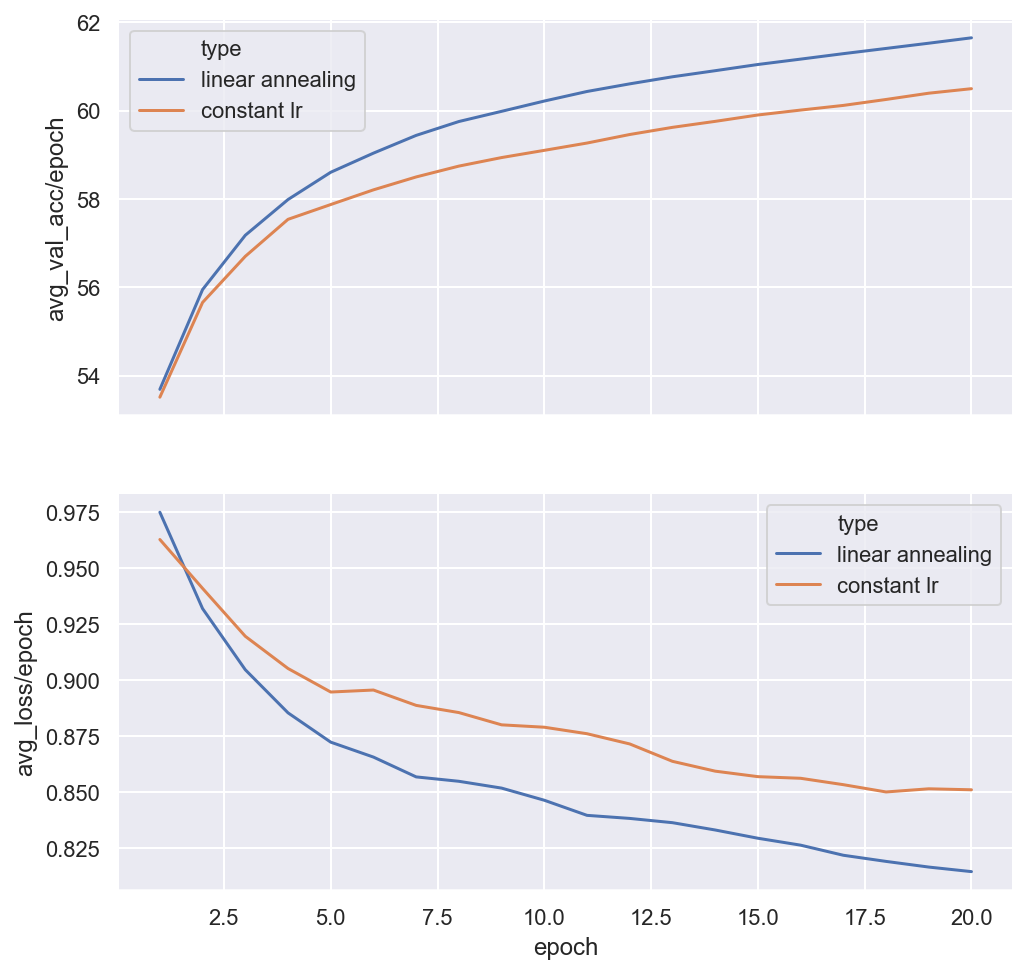

In [395]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

# Set up the matplotlib figure
f, axes = plt.subplots(2 ,figsize=(8,8),sharex=True)
sns.despine(left=True)
sns.lineplot(x="epoch", y="avg_val_acc/epoch",hue = 'type',data=df,ax=axes[0])
sns.lineplot(x="epoch", y="avg_loss/epoch",hue = 'type',data=df,ax=axes[1])
plt.savefig('res/3.4_fig1.jpg')
plt.show()

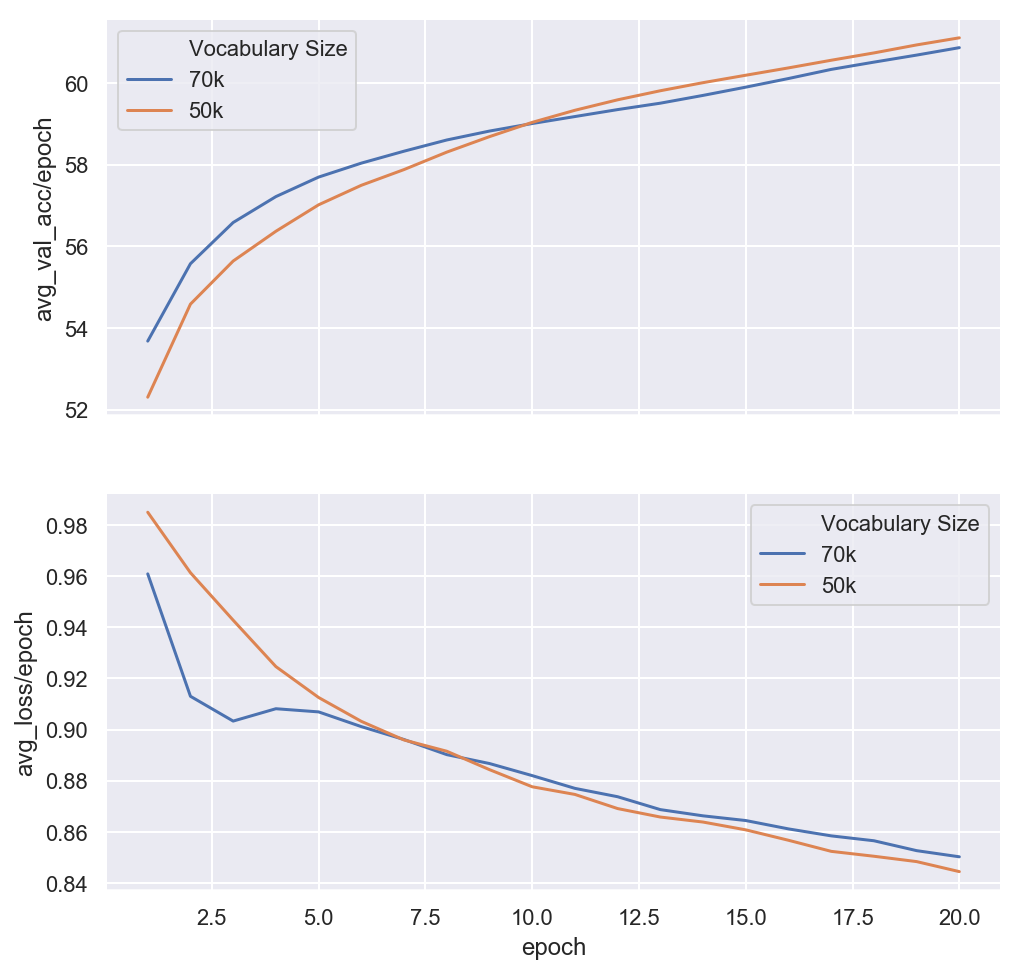

In [429]:
# Set up the matplotlib figure
f, axes = plt.subplots(2 ,figsize=(8,8),sharex=True)
sns.despine(left=True)
sns.lineplot(x="epoch", y="avg_val_acc/epoch",hue = 'Vocabulary Size',data=df_v,ax=axes[0])
sns.lineplot(x="epoch", y="avg_loss/epoch",hue = 'Vocabulary Size',data=df_v,ax=axes[1])
plt.savefig('res/3.4_fig2.jpg')
plt.show()

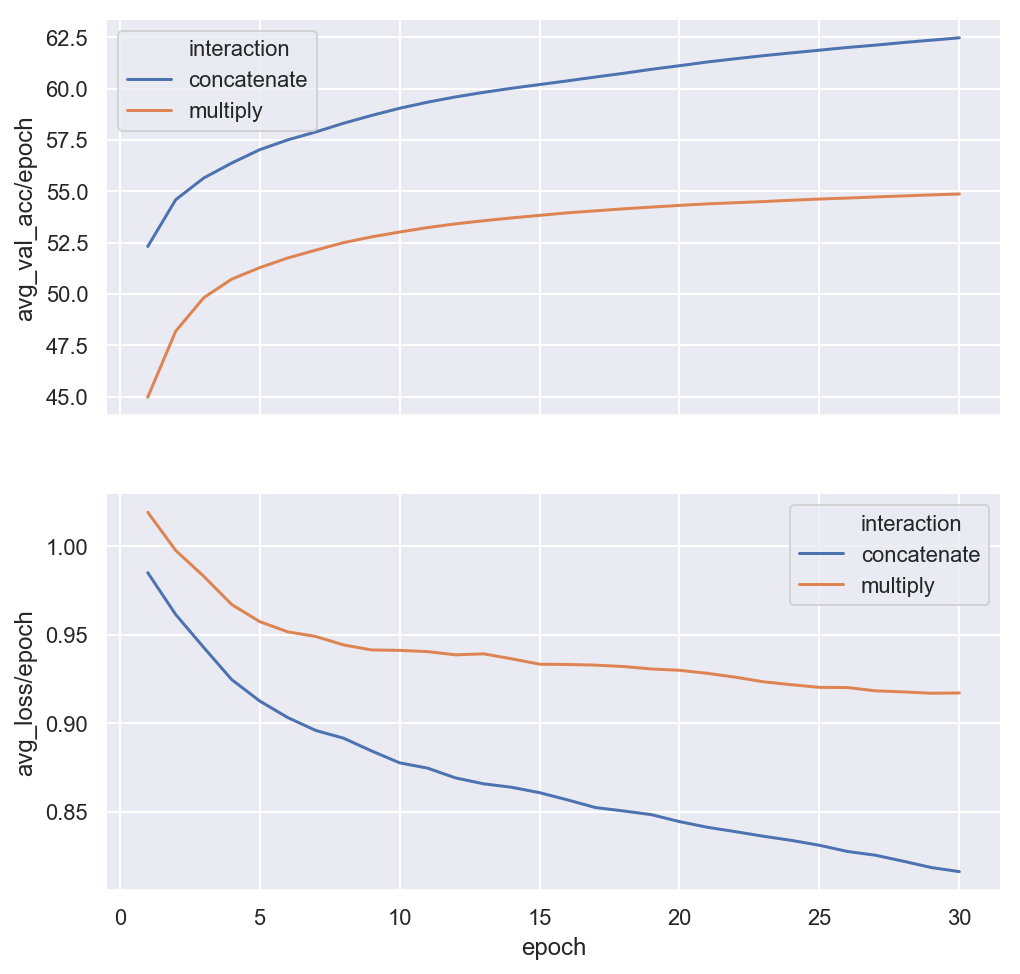

In [440]:
# Set up the matplotlib figure
f, axes = plt.subplots(2 ,figsize=(8,8),sharex=True)
sns.despine(left=True)
sns.lineplot(x="epoch", y="avg_val_acc/epoch",hue = 'interaction',data=df_inter,ax=axes[0])
sns.lineplot(x="epoch", y="avg_loss/epoch",hue = 'interaction',data=df_inter,ax=axes[1])
plt.savefig('res/3.4_fig3.jpg')
plt.show()

In [421]:
# get MNLI evaluation result using 50k+30epoch+concat
train_loader = get_dataloader(mnli_train_telephone,  max_sentence_length=MAX_SENTENCE_LENGTH, batch_size=32)
val_loader = get_dataloader(mnli_val_telephone,  max_sentence_length=MAX_SENTENCE_LENGTH, batch_size=32)
print('Accuracy on telephone:',test_model(val_loader,best_model))
train_loader = get_dataloader(mnli_train_fiction,  max_sentence_length=MAX_SENTENCE_LENGTH, batch_size=32)
val_loader = get_dataloader(mnli_val_fiction,  max_sentence_length=MAX_SENTENCE_LENGTH, batch_size=32)
print('Accuracy on fiction:',test_model(val_loader,best_model))
train_loader = get_dataloader(mnli_train_slate,  max_sentence_length=MAX_SENTENCE_LENGTH, batch_size=32)
val_loader = get_dataloader(mnli_val_slate,  max_sentence_length=MAX_SENTENCE_LENGTH, batch_size=32)
print('Accuracy on slate:',test_model(val_loader,best_model))
train_loader = get_dataloader(mnli_train_government,  max_sentence_length=MAX_SENTENCE_LENGTH, batch_size=32)
val_loader = get_dataloader(mnli_val_government,  max_sentence_length=MAX_SENTENCE_LENGTH, batch_size=32)
print('Accuracy on government:',test_model(val_loader,best_model))
train_loader = get_dataloader(mnli_train_travel,  max_sentence_length=MAX_SENTENCE_LENGTH, batch_size=32)
val_loader = get_dataloader(mnli_val_travel,  max_sentence_length=MAX_SENTENCE_LENGTH, batch_size=32)
print('Accuracy on travel:',test_model(val_loader,best_model))

Accuracy on telephone: 42.48756218905473
Accuracy on fiction: 42.71356783919598
Accuracy on slate: 39.421157684630735
Accuracy on government: 43.40551181102362
Accuracy on travel: 42.871690427698574
